<a href="https://colab.research.google.com/github/Dots11/DavesProjects/blob/master/05_Transfer_in_TensorFlow_part_2_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Transfer Learning with TensorFlow Part 2: Fine-tuning

In the previous notebook, we covered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning: fine-tuning.

In [ ]:
# Check if we are using a gpu
!nvidia-smi

Wed Aug 24 19:27:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    28W /  70W |   4904MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In previous notebooks, we've created a bunch of helper functions, now we could rewrite them all, but this is tedious.

So, it's a good idea to put functions you'll want to use again in a script you can download and import into your notebooks (or elsewhere).

We've done this for some of the functions we've used previously here: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-08-24 19:27:08--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-08-24 19:27:08 (105 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [ ]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

**Note:** If you're running this notebook in Google Colab, when it times out in Colab will delete `helper_functions.py`, so you'll have to redownload it if you want access to your helper functions.

##Let's get some data
This time we're going to see how we can use the pretrained models within tf.keras.applications and apply them to our own problem (recognizing images of food).

Link: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [ ]:
# Get 10% of training data of 10 classes of Food101
!wget = https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2022-08-24 19:27:08--  http://=/
Resolving = (=)... failed: Name or service not known.
wget: unable to resolve host address ‘=’
--2022-08-24 19:27:08--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.123.128, 142.250.97.128, 142.251.107.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.123.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   263MB/s    in 0.6s    

2022-08-24 19:27:09 (263 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]

FINISHED --2022-08-24 19:27:09--
Total wall clock time: 0.8s
Downloaded: 1 files, 161M in 0.6s (263 MB/s)


In [ ]:
unzip_data("10_food_classes_10_percent.zip")

In [ ]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/tes

In [ ]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"


In [ ]:
# Instead of ImageDataGenerator, we are goingto use image_dataset_from_directory

import tensorflow as tf

IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir,
                                                                            image_size = IMG_SIZE,
                                                                            label_mode = "categorical",
                                                                            batch_size = BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir,
                                                                image_size = IMG_SIZE,
                                                                label_mode = "categorical",
                                                                batch_size = BATCH_SIZE)



Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Checking the input and output shapes going into our model

train_data_10_percent # 'None' is meant to be 32

# "Create batches of 32 images of 224 x 224 split into red, green, blue colour channels"

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [ ]:
# Checking out class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1): # take unravels a batch, which will come as 'images' and 'labels'
  print(images, labels) # in a tuple one after another

tf.Tensor(
[[[[ 18.          11.          18.        ]
   [ 17.785713    10.785714    17.785713  ]
   [ 16.07653      9.505102    16.290817  ]
   ...
   [ 36.571407    34.571407    35.999935  ]
   [ 40.331627    36.331627    37.331627  ]
   [ 37.285645    33.285645    34.285645  ]]

  [[ 19.188776    12.188776    19.188776  ]
   [ 18.          11.          18.        ]
   [ 17.658163    11.086736    17.87245   ]
   ...
   [ 36.785736    34.785736    36.214264  ]
   [ 41.          37.          38.        ]
   [ 40.499966    36.499966    37.499966  ]]

  [[ 23.071426    16.071428    23.071426  ]
   [ 20.62755     13.62755     20.62755   ]
   [ 20.571428    14.          20.785713  ]
   ...
   [ 39.357185    37.357185    38.785713  ]
   [ 41.770405    37.770405    38.770405  ]
   [ 41.785713    37.785713    38.785713  ]]

  ...

  [[ 21.484608    12.199025    10.413289  ]
   [ 24.03531     14.749727    12.963991  ]
   [ 20.469065     8.846737    10.015109  ]
   ...
   [254.         254.   

Dataset is now ready

## Model 0: Building a transfer learning model using the Keras Functional API

The sequential API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more flexibility with our models - https://www.tensorflow.org/guide/keras/functional


In [ ]:
# 1. Create a model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top = False)  # we want to add our own dense layer at the top with the same no. of output neurons we are working with (10)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False # it does not get trained

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224,224, 3), name = "input_layer")

# 4. If using ResNet50V2 you will need to normalize inputs (you don't have to for EfficientNet(s))
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255.)(inputs) # Not needed if we are using EfficientNets

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile for the model

model_0.compile(loss = "categorical_crossentropy",
                optimizer= tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

# 10. Fit the model and save its history

history_0 = model_0.fit(train_data_10_percent,
                        epochs = 5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data = test_data,
                        validation_steps = int(0.25 * len(test_data)),
                        callbacks = [create_tensorboard_callback(dir_name = "transfer_learning",
                                                                 experiment_name = "10_percent_feature_extraction")])

Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20220824-192713
Epoch 1/5
24/24 [==============================] - 12s 207ms/step - loss: 1.9016 - accuracy: 0.4053 - val_loss: 1.3356 - val_accuracy: 0.6891
Epoch 2/5
24/24 [==============================] - 3s 130ms/step - loss: 1.1618 - accuracy: 0.7333 - val_loss: 0.9396 - val_accuracy: 0.7878
Epoch 3/5
24/24 [==============================] - 3s 132ms/step - loss: 0.8493 - accuracy: 0.8053 - val_loss: 0.7567 - val_accuracy: 0.8240
Epoch 4/5
24/24 [==============================] - 3s 132ms/step - loss: 0.6981 - accuracy: 0.8267 - val_loss: 0.6868 - val_accuracy: 0.8191
Epoch 5/5
24/24 [==============================] - 3s 133ms/step - loss: 0.6012 - accuracy: 0.8653 - val_loss: 0.6213 - val_accuracy: 0.8306


In [ ]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 6s 67ms/step - loss: 0.6161 - accuracy: 0.8352


[0.6161059737205505, 0.8352000117301941]

In [ ]:
# Check the layers in our base model

for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_4
1 rescaling_3
2 normalization_3
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_d

In [ ]:
# Get summary of base model (to give context of layers)
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_3 (Rescaling)        (None, None, None,   0           ['input_4[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_3 (Normalization  (None, None, None,   7          ['rescaling_3[0][0]']            
 )                              3)                                                   

In [ ]:
# How about a summary of our whole model?
model_0.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


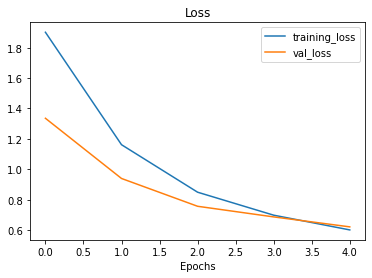

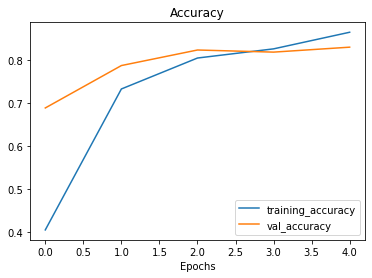

In [ ]:
# Check out our model#s training curves
plot_loss_curves(history_0)

## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through ``base_model` of shape (None, 7,7, 1280).

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280).

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D

In [ ]:
# Define the imput shape
input_shape = (1,4,4,3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape) # turns into a Tensor
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D Layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor) # likewise what we did with the functional API base_model
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n") # tensor to a vector - removed two inner dimensions

# Check the shape of different tensors
print(f"Check the shape of input tensor {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Check the shape of input tensor (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)


In [ ]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

**Practice:** try to do the same with the above two cells but using `GlobalMaxPool2D`... and see what happens.

**Note:** One of the reasons feature extraction transfer learning is named how it is because what often happens is pretrained model outputs a **feature vector** (a long tensor of numbers whihc represents the learned representation of the model on a particular sample, in our case, this is the output of the `tf.keras.layers.GlobalAveragePooling2D()` layer) which can then be used to extract patterns out of, for our own specific problem.

In [ ]:
# Getting a feature vector using GlobalMaxPool2D method

# Define input shape
input_shape = (1,4,4,3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape) # turns into a tensor
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D Layer
global_max_pool_tensor = tf.keras.layers.GlobalMaxPool2D()(input_tensor) # likewise what we did with the functional API base_model
print(f"2D global max pool random tensor:\n {global_max_pool_tensor}\n") # tensor to a vector

# Check the shape of different tensors
print(f"Check the shape of input tensor {input_tensor.shape}")
print(f"Shape of Global Max Pooled 2D tensor: {global_max_pool_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global max pool random tensor:
 [[0.9058464 1.1603122 1.6994323]]

Check the shape of input tensor (1, 4, 4, 3)
Shape of Global Max Pooled 2D tensor: (1, 3)


## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with 10% of the training data, but how does it go with 1% of the training data ... how about we set up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation.
2. `model_2` = use feature extraction transfer learning with 10% of the trainng with data augmnetation.

3. `model_3` - use fine_tuning transfer learning on 10% of the training data with data augmentation.

4. `model_4` - use fine_tuning transfer learning on 100% of the training data with data augmentation.

**Note:** throughout all experiments the same test dataset will be used to evaluate our model... this ensures consistency across evaluation metrics.


## Getting and preprocessing data for model_1

In [ ]:
# Download and unzip data = preprocessed from Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2022-08-24 19:27:46--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.107.128, 74.125.196.128, 74.125.31.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.107.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.1’

10_food_classes_1_p 100%[===================>] 127.42M   274MB/s    in 0.5s    

2022-08-24 19:27:47 (274 MB/s) - ‘10_food_classes_1_percent.zip.1’ saved [133612354/133612354]



In [ ]:
# Create training and test directory paths
train_dir_1_percent = "10_food_classes_1_percent/train/" 
test_dir =  "10_food_classes_1_percent/test/"

In [ ]:
# How many images we are working with
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'

In [ ]:
# Setup data loaders
IMG_SIZE = (224,224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir_1_percent,
                                                                           label_mode = "categorical",
                                                                           image_size = IMG_SIZE,
                                                                           batch_size = BATCH_SIZE) # default = 3

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir, 
                                                                label_mode = "categorical",
                                                                image_size = IMG_SIZE,
                                                                batch_size = BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into our model

To add data augmentation right into our models, we can use the layers inside:

* `tf.keras.layers.preprocessing()`

This is a recent feature (TF 2.2 onwards)
We can see the benefits of doing this within the TensorFlow Data augmentation documentation: https://www.tensorflow.org/tutorials/images/data_augmentation#use_keras_preprocessing_layers

Off the top of our heads, after reading the docs, the benefits of using data_augmentation inside the model are:
* Preprocessing of images (augmenting them) happens on the GPU (much faster), rather than the CPU.

* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere.

**Note** `ImageDataGenerator` augments images through the CPU, while the newer `preprocessing` layers augments images through the GPU


In [ ]:
print(tf.__version__)

2.8.2


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation state with horizontal flipping, rotations, zooms, etc.
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescale(1./255) # Keep for models like ResNet50V2 but EfficientNet's having rescaling built in
], name = "data_augmentation")

In [ ]:
### Visualize our dta

### Visualisze our data augmentation layer (and see what happens to our data)

3047807.jpg
[[[  9  10  12]
  [ 12  13  15]
  [  9  10  12]
  ...
  [132 134 149]
  [133 135 150]
  [139 141 156]]

 [[ 10  11  13]
  [ 14  15  17]
  [ 14  15  17]
  ...
  [132 134 149]
  [131 133 148]
  [136 138 153]]

 [[  7   8  10]
  [  9  10  12]
  [ 12  13  15]
  ...
  [134 136 151]
  [132 134 149]
  [135 137 152]]

 ...

 [[175 175 163]
  [175 173 161]
  [178 176 163]
  ...
  [165 161 149]
  [164 160 148]
  [163 159 147]]

 [[174 174 162]
  [176 174 162]
  [179 177 164]
  ...
  [163 159 147]
  [163 159 147]
  [163 159 147]]

 [[172 172 160]
  [175 173 161]
  [180 178 165]
  ...
  [162 159 144]
  [163 160 145]
  [165 162 147]]]


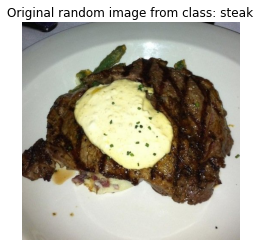

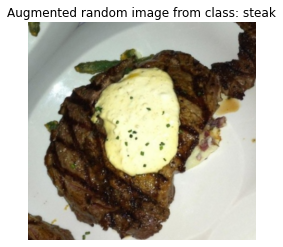

In [ ]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image
print(random_image)

# Read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False);
print(img)

# Now let's plot our augmented random image
augmented_img = data_augmentation(img, training = True)
plt.figure()
plt.imshow(augmented_img/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);
#print(augmented_img)


In [ ]:
train_data_1_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [ ]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name = "input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of the base model

x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as an output
outputs = layers.Dense(10, activation = "softmax", name="output_layer")(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

# Fit the model

history_1_percent = model_1.fit(train_data_1_percent,
                                epochs = 5,
                                steps_per_epoch = len(train_data_1_percent),
                                validation_data = test_data,
                                validation_steps = int(0.25 * len(test_data)),
                                # Track model training logs
                                callbacks = [create_tensorboard_callback(dir_name = "transfer_learning",
                                                                         experiment_name = "1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20220824-192752
Epoch 1/5


3/3 [==============================] - ETA: 0s - loss: 2.4082 - accuracy: 0.0571

3/3 [==============================] - 9s 2s/step - loss: 2.4082 - accuracy: 0.0571 - val_loss: 2.2319 - val_accuracy: 0.1908
Epoch 2/5
3/3 [==============================] - 3s 1s/step - loss: 2.1812 - accuracy: 0.3143 - val_loss: 2.1078 - val_accuracy: 0.2632
Epoch 3/5
3/3 [==============================] - 3s 2s/step - loss: 1.9342 - accuracy: 0.4286 - val_loss: 2.0087 - val_accuracy: 0.3174
Epoch 4/5
3/3 [==============================] - 2s 920ms/step - loss: 1.8298 - accuracy: 0.5429 - val_loss: 1.9222 - val_accuracy: 0.3964
Epoch 5/5
3/3 [==============================] - 2s 990ms/step - loss: 1.6693 - accuracy: 0.6000 - val_loss: 1.8162 - val_accuracy: 0.4671


Transfer learning was able to equal our models built from scratch with 10x more data, with only 7 images per class!!

In [ ]:
model_1.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, 3)          0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [ ]:
# As per above, only the parameters in the output layer are trainable, the rest lie in the efficientnetb0 layer where patterns are pre-learned on ImageNet

In [ ]:
# Evaluate on the full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 6s 67ms/step - loss: 1.8283 - accuracy: 0.4516


[1.8282791376113892, 0.45159998536109924]

In [ ]:
#Takes a bit longer and performs a little worse than training dataset as it is looking at all of the images and not 25% of them

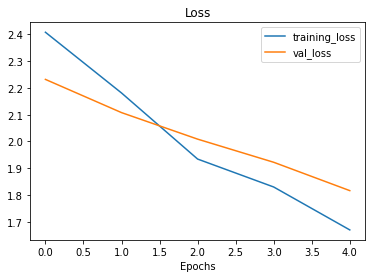

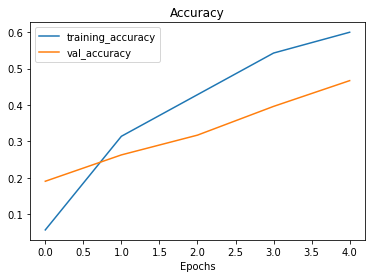

In [ ]:
# How do the model with 1% of the data and data augmentatin loss curves look?
plot_loss_curves(history_1_percent)

##Model 2: feature extraction transfer learning model with 10% of data and data augmentation

In [ ]:
# Get 10% of data...
#!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
# unzip_data(10_food_classes_1o_percent)

train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [ ]:
#How many images are in our directories?
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/tes

In [ ]:
# Set data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir_10_percent,
                                                                         label_mode="categorical",
                                                                         image_size = IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir,
                                                                label_mode = "categorical",
                                                                image_size = IMG_SIZE)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
data_augmentation.summary() 
# already done, though let's practice rewriting one again

Model: "data_augmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_2 (RandomFlip)  (512, 512, 3)             0         
                                                                 
 random_rotation_2 (RandomRo  (512, 512, 3)            0         
 tation)                                                         
                                                                 
 random_zoom_2 (RandomZoom)  (512, 512, 3)             0         
                                                                 
 random_height_2 (RandomHeig  (None, 512, 3)           0         
 ht)                                                             
                                                                 
 random_width_2 (RandomWidth  (None, None, 3)          0         
 )                                                               
                                                 

In [ ]:
# Create model 2 with data augmentation built in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layers
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2),
    # preprocessing.Rescaling(1./255.) # if you're using a model such as ResNet50V2, you'll need to rescale your data, efficientnet has rescaling already built-in
], name = "data_augmentation")

# Setup the input shape to our model
input_shape = (224,224, 3)

# Create a frozen base model (also called the backbone) "Tesla uses ResNet50 for their models
base_model = tf.keras.applications.EfficientNetB0(include_top=False) # we are building our own custom top (input layer)
base_model.trainable = False

# Create the inputs and outputs (including the layers in between)
inputs = layers.Input(shape=input_shape, name = "input_layer")
x = data_augmentation(inputs) # augment our training images (augmentation doesn't occur on test data)
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, this also ensures that batchnorm layers don't get updated https://keras.io/guides/transfer_learning/#build-a-model
x = layers.GlobalAveragePooling2D(name = "global_average_pooling_2D")(x)
outputs = layers.Dense(10, activation = "softmax", name =  "output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])



### Creating a modelcheckpoint callback

The ModelCheckpoint callback intermediately saves our model (the full model or just the weights) during training. This is useful so we can come and start where we left off.

In [ ]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only = True,
                                                         save_best_only=False,
                                                         save_freq = "epoch", # save every epoch
                                                         verbose = 1)

### Fit model 2 passing in the ModelCheckpoint callback

In [ ]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs = initial_epochs,
                                          validation_data = test_data,
                                          validation_steps = int(0.25 * len(test_data)),
                                          callbacks=[create_tensorboard_callback(dir_name = "transfer_learning",
                                                                                 experiment_name = "10_percent_data_aug"),
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20220824-192827
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0051 - accuracy: 0.3493
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 15s 353ms/step - loss: 2.0051 - accuracy: 0.3493 - val_loss: 1.4913 - val_accuracy: 0.6612
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3827 - accuracy: 0.6653
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 6s 262ms/step - loss: 1.3827 - accuracy: 0.6653 - val_loss: 1.0634 - val_accuracy: 0.7714
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0424 - accuracy: 0.7720
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 7s 300ms/step - loss: 1.0424 - accuracy: 0.7720 - val_loss: 0.8346 - val_accuracy: 0.8092
Epo

In [ ]:
# What were model_0 results?
model_0.evaluate(test_data)

79/79 [==============================] - 6s 68ms/step - loss: 0.6161 - accuracy: 0.8352


[0.6161059141159058, 0.8352000117301941]

In [ ]:
# Check model_2 result on all test_data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 6s 67ms/step - loss: 0.6967 - accuracy: 0.8092


[0.696716845035553, 0.8091999888420105]

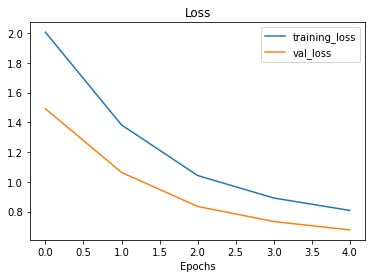

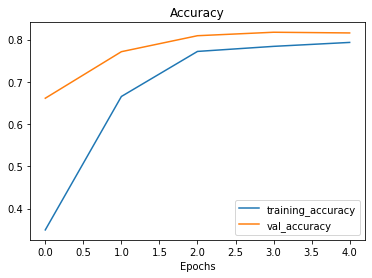

In [ ]:
# Plot loss model curves
plot_loss_curves(history_10_percent_data_aug)

###Loading in checkpointed weights
Loading in checkpointed weights returns a models to a specific checkpoint


In [ ]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [ ]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 6s 68ms/step - loss: 0.6967 - accuracy: 0.8092


In [ ]:
# If the results from our previously evaluated model_2 match the loaded weights, every
results_10_percent_data_aug == loaded_weights_model_results

False

In [ ]:
results_10_percent_data_aug

[0.696716845035553, 0.8091999888420105]

In [ ]:
loaded_weights_model_results

[0.6967169642448425, 0.8091999888420105]

In [ ]:
# Check to see if loaded model results are very close to our previous non-loaded model
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [ ]:
# Chwck the differrences between the two results
print(np.array(results_10_percent_data_aug)-np.array(loaded_weights_model_results))

[-1.1920929e-07  0.0000000e+00]


In [ ]:
model_2.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_2D (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [ ]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_5 (Rescaling)        (None, None, None,   0           ['input_6[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_5 (Normalization  (None, None, None,   7          ['rescaling_5[0][0]']            
 )                              3)                                                   

In [ ]:
### Mod

## Model 3: fine-tuning an existing model on 10% of the data
**Note:** Fine-tuning usually works best *after* training a feature extraction model for a few epochs with large amounts of custom data.

In [ ]:
# Layers in loaded model
model_2.layers

In [ ]:
# Are these layers trainable?
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fec34f36b50> True
<keras.engine.sequential.Sequential object at 0x7fec34f36750> True
<keras.engine.functional.Functional object at 0x7febaf30d7d0> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7febaf441690> True
<keras.layers.core.dense.Dense object at 0x7febaf38f310> True


In [ ]:
# The functional layer (base model) is not trainable, earlier we created the frozen base model and set base.model.trainable = False

In [ ]:
# What layers are in our base model (EfficientNetB0) and are they trainable?
for i, layer in enumerate(model_2.layers[2].layers): # indexing on the base_model layer, and getting a counted list of its layers
  print(i, layer.name, layer.trainable)

0 input_6 False
1 rescaling_5 False
2 normalization_5 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
# All layers in the functional layer are not trainable

In [ ]:
# How many trainable variables are in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [ ]:
# There are currently no trainable variables in our EfficientNetB0 model

# We want to make at least 10 of them trainable

# To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable = True
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

In [ ]:
for i, layer in enumerate(base_model.layers[:-10]):
  print(i, layer.name)

0 input_6
1 rescaling_5
2 normalization_5
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_d

In [ ]:
# Recompile (we have to recompile our models every time we make a change) - because base_model is a part of model_2, we have to recompile model_2 entirely
model_2.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), # when fine tuning you typically want to lower the learning rate by 10x*
                metrics = ["accuracy"])

**Note:** When using fine-tuning it's best practice to lower your learning rate by some amound. How much? This is a parameter you can tune. But a good rule of thumb is at least 10x (though different sources will claim other values) to avoid your base_model from overfitting
A good resource for information on this is the ULMFiT paper: https://arxiv.org/abs/1801.06146

In [ ]:
# Check which layers are tunable (trainable)
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_6 False
1 rescaling_5 False
2 normalization_5 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
# Now we've unfrozen some of the layers closer to the top, how many trainable variables are there?
print(len(model_2.trainable_variables))

12


In [ ]:
model_2.trainable_variables

[<tf.Variable 'block7a_se_reduce/kernel:0' shape=(1, 1, 1152, 48) dtype=float32, numpy=
 array([[[[-0.05485657,  0.07178846,  0.01534605, ..., -0.09284662,
            0.0104828 , -0.02693838],
          [-0.03157939,  0.02819107, -0.05579546, ...,  0.00487578,
            0.12001809, -0.06901816],
          [-0.07792544,  0.12601745,  0.03935236, ...,  0.03086486,
           -0.01581392,  0.1306234 ],
          ...,
          [-0.07692936,  0.19920062,  0.17471024, ...,  0.03312391,
           -0.04528928, -0.09214652],
          [ 0.01010198,  0.06855008,  0.05820991, ...,  0.00131649,
           -0.08952942, -0.00476829],
          [ 0.03583075, -0.01228165,  0.04561347, ..., -0.00822134,
           -0.07354517, -0.06507882]]]], dtype=float32)>,
 <tf.Variable 'block7a_se_reduce/bias:0' shape=(48,) dtype=float32, numpy=
 array([-0.10886215, -0.13624744, -0.15257476,  0.14799541, -0.08512902,
        -0.12059905, -0.08779966, -0.08187538, -0.06925284, -0.12518929,
        -0.0819265 ,

In [ ]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers):
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs = fine_tune_epochs,
                                               validation_data = test_data,
                                               validation_steps = int(0.25 * len(test_data)), 
                                               initial_epoch = history_10_percent_data_aug.epoch[-1], # It will start training from previous last epoch
                                               callbacks=[create_tensorboard_callback(dir_name = "transfer_learning",
                                                                                     experiment_name = "10_percent_fine_tune_last_10")])
                                               


Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20220824-192932
Epoch 5/10
24/24 [==============================] - 15s 376ms/step - loss: 0.6905 - accuracy: 0.8227 - val_loss: 0.5461 - val_accuracy: 0.8076
Epoch 6/10
24/24 [==============================] - 7s 298ms/step - loss: 0.5601 - accuracy: 0.8280 - val_loss: 0.5025 - val_accuracy: 0.8289
Epoch 7/10
24/24 [==============================] - 6s 246ms/step - loss: 0.4913 - accuracy: 0.8520 - val_loss: 0.4993 - val_accuracy: 0.8322
Epoch 8/10
24/24 [==============================] - 7s 297ms/step - loss: 0.4388 - accuracy: 0.8667 - val_loss: 0.4539 - val_accuracy: 0.8405
Epoch 9/10
24/24 [==============================] - 7s 265ms/step - loss: 0.3937 - accuracy: 0.8867 - val_loss: 0.4867 - val_accuracy: 0.8306
Epoch 10/10
24/24 [==============================] - 8s 317ms/step - loss: 0.3561 - accuracy: 0.9027 - val_loss: 0.5065 - val_accuracy: 0.8289


In [ ]:
# Evaluate the fine-tuned mode (model_3 which is actually model_2 fine_tuned for another 5 epochs)
results_fine_tune_10_percent = model_2.evaluate(test_data) # note test_data remains entirely the same throughout this workbook

79/79 [==============================] - 6s 68ms/step - loss: 0.4983 - accuracy: 0.8276


In [ ]:
results_10_percent_data_aug

[0.696716845035553, 0.8091999888420105]

In [ ]:
# We gained a 3 % improvement in performance by fine-tuning the last 10 layers for 5 epochs

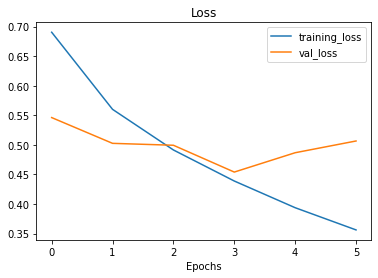

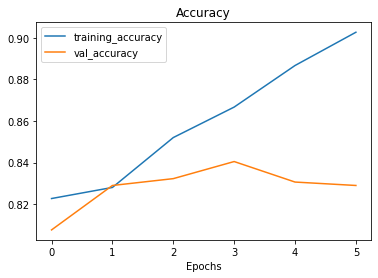

In [ ]:
# Check out the loss curves of our fine_tuning model
plot_loss_curves(history_fine_10_percent_data_aug)

###Comparing our model's results before and after fine tuning

The `plot_loss_curves` function works great with models which have only been fit once, however, we want something to compare one series of running `fit()` with another (e.g. before and after fine_tuning).

In [ ]:
# Let's create a function to compare training histories
def compare_historys(original_history, new_history, initial_epochs = 5):
  """
  Compares two TensorFlow History objects.
  """

  # Get original history measurements
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine original history metrics with new_history metrics
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  # Make plots for accuracy
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,1)
  plt.plot(total_acc, label="Training Accuracy")
  plt.plot(total_val_acc, label="Training Val Accuracy")
  plt.plot([initial_epochs -1, initial_epochs -1], plt.ylim(), label = "Start Fine Tuning")
  plt.legend(loc = "lower right")
  plt.title("Training and Validation Accuracy")

   # Make plots for loss
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,2)
  plt.plot(total_loss, label="Training Loss")
  plt.plot(total_val_loss, label="Training Val Loss")
  plt.plot([initial_epochs -1, initial_epochs -1], plt.ylim(), label = "Start Fine Tuning")
  plt.legend(loc = "upper right")
  plt.title("Training and Validation Loss")

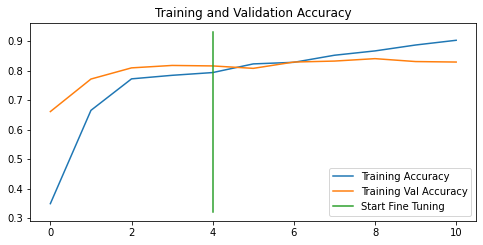

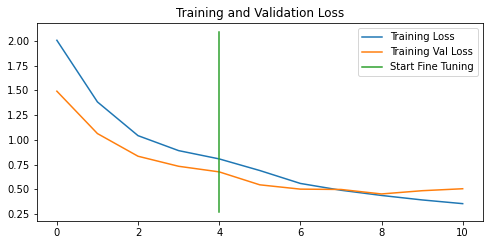

In [ ]:
compare_historys(history_10_percent_data_aug,
                 history_fine_10_percent_data_aug,
                 initial_epochs = 5)

## Model 4: Fine-tuning and existing model on all of the **data**

In [ ]:
# Download and unzip 10 classes of Food101 with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")


--2022-08-24 19:30:28--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.204.128, 172.217.203.128, 172.253.123.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip.2’

10_food_classes_all 100%[===================>] 495.13M   172MB/s    in 2.9s    

2022-08-24 19:30:31 (172 MB/s) - ‘10_food_classes_all_data.zip.2’ saved [519183241/519183241]



In [ ]:
# Setup training and test dir
train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"


In [ ]:
# How many images are we working with now?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 label_mode = "categorical",
                                                                                 image_size = IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode ="categorical",
                                                                image_size = IMG_SIZE)
                                                                

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset we've loaded in is the same as what we've been using for previous experiments (all experiments used the same test dataset)

Let's verify this...

In [ ]:
results_fine_tune_10_percent

[0.4983333945274353, 0.8276000022888184]

To train a fine_tuning model (model_4) we need to revert model_2 back to its feature extraction weights.

In [ ]:
# Load weights from checkpoint, that way we can fine_tune from 
# the same stage the 10 percent data model was fine_tuned from.
model_2.load_weights(checkpoint_path)

In [ ]:
# Let's evaluate model_2 now
model_2.evaluate(test_data)

79/79 [==============================] - 6s 69ms/step - loss: 0.6967 - accuracy: 0.8092


[0.6967169642448425, 0.8091999888420105]

In [ ]:
# Check to see if our model_2 has been reverted back to feature extraction results
results_10_percent_data_aug

[0.696716845035553, 0.8091999888420105]

Alright, the previous steps might seem quite confusing but all we've done is:
1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data with data augmentation (model_2) and we saved the model's weights using `ModelCheckpoint` callback.
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen (model_3).
3. Saved the results and training logs each time.
4. Reloaded the model from step 1 to do the same steps as step 2 except this time we're going to use all the data (model_4)

In [ ]:
# Check which layers are tunable in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_2D True
4 output_layer True


In [ ]:
# Let's drill into our base_model (efficientnetB0) and see what layers are trainable
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_6 False
1 rescaling_5 False
2 normalization_5 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
# then we need to recompile our model
model_2.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
                metrics = ["accuracy"])

In [ ]:
# Continue to train and fine-tune the model to our data (100% of the training data)
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs = fine_tune_epochs,
                                           validation_data = test_data,
                                           validation_steps = (0.25 * len(test_data)),
                                           initial_epoch = history_10_percent_data_aug.epoch[-1],
                                           callbacks=[create_tensorboard_callback(dir_name = "transfer_learning",
                                                                                 experiment_name = "full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20220824-193205
Epoch 5/10
235/235 [==============================] - 52s 195ms/step - loss: 0.7280 - accuracy: 0.7624 - val_loss: 0.4322 - val_accuracy: 0.8422
Epoch 6/10
235/235 [==============================] - 41s 175ms/step - loss: 0.5973 - accuracy: 0.8077 - val_loss: 0.3773 - val_accuracy: 0.8656
Epoch 7/10
235/235 [==============================] - 36s 153ms/step - loss: 0.5357 - accuracy: 0.8276 - val_loss: 0.4029 - val_accuracy: 0.8562
Epoch 8/10
235/235 [==============================] - 38s 162ms/step - loss: 0.4795 - accuracy: 0.8459 - val_loss: 0.3432 - val_accuracy: 0.8891
Epoch 9/10
235/235 [==============================] - 37s 158ms/step - loss: 0.4451 - accuracy: 0.8588 - val_loss: 0.3469 - val_accuracy: 0.8859
Epoch 10/10
235/235 [==============================] - 33s 138ms/step - loss: 0.4289 - accuracy: 0.8599 - val_loss: 0.3248 - val_accuracy: 0.8906


In [ ]:
!nvidia-smi

Wed Aug 24 19:36:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0    44W /  70W |   4904MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Let's evaluate on all of the test data
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 6s 69ms/step - loss: 0.3124 - accuracy: 0.8976


[0.31236276030540466, 0.897599995136261]

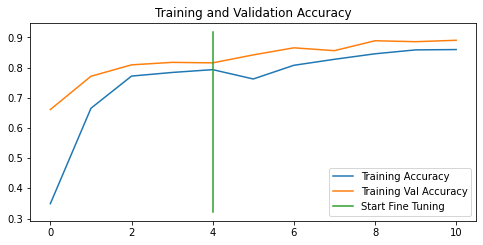

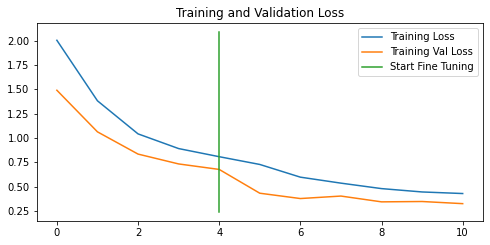

In [ ]:
# How did fine-tuning go with more data?
compare_historys(original_history=history_10_percent_data_aug,
                 new_history = history_fine_10_classes_full,
                 initial_epochs = 5)

## Viewing our experiment data on TensorBoard

**Note:** Anything you upload to Tensorboard.dev is going to be public. So if you have private data, do not upload.

In [ ]:
#  View tensorboard logs of transfer learning modelling experiments (should ~4 models)
# Upload tensorboard dev records

!tensorboard dev upload --logdir ./transfer_learning \
  --name "Transfer Learning Experiments with 10 Food101 Classes" \
  --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning." \
  --one_shot # exits the uploader once it finished uploading



***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./transfer_learning

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=dcqgJ5mbuV2Op42Ov42hZ9WmccSSAE&prompt=consent&access_type=o

My Tensorflow models are located here: https://tensorboard.dev/experiment/Ka3vqtNBSlqgurd2FpD4BQ/

In [ ]:
#View all of your uploaded TensorBoard.dev experiments (public)
!tensorboard dev list

2022-08-25 09:05:17.216860: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected

***** TensorBoard Uploader *****

This will list all experiments that you've uploaded to
https://tensorboard.dev. TensorBoard.dev experiments are visible
to everyone. Do not upload sensitive data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) 

In [ ]:
#Delete an experiment
#!tensorboard dev delete --experiment_id Ka3vqtNBSlqgurd2FpD4BQ